In [ ]:
#import ipdb;ipdb.set_trace()

: 

In [18]:
import numpy as np
from tqdm.notebook import trange

def warmup_ours(lr, step, warmup):
    min_lr = 1e-3*lr
    return  (lr - min_lr)*(step / warmup) + min_lr

# import jax.numpy as jnp
def warmup_deepmind(lr, step, warmup): #TODO: Jaxify, my had jax has no attribute __src__ bug
    return np.array(step, dtype=np.float32) / int(warmup) * lr


def test(batch_size, num_epochs):
    
    train_images_per_epoch = 1281167
    warmup_epochs = int(num_epochs // 100)
    warmup_steps = (warmup_epochs * train_images_per_epoch) // batch_size
    max_steps = (num_epochs * train_images_per_epoch) // batch_size
    
    
    ours = []
    deepminds = []
    for step in trange(max_steps):
        for lr in np.arange(1e-5, 1.0, 0.0005):
            scaled_lr = max_lr = lr.item(0) * (batch_size / 256)
            ours.append(warmup_ours(scaled_lr, step, warmup_steps))
            deepminds.append(warmup_deepmind(scaled_lr, step, warmup_steps))
    
    diffs = np.array([abs(t[0]-t[1]) for t in zip(ours, deepminds)])
    return np.mean(diffs)

print("Warmup Average Difference")
test(4096, 100)

Warmup Average Difference


  0%|          | 0/31278 [00:00<?, ?it/s]

0.3928785634835985

In [25]:
import numpy as np
from tqdm.notebook import trange

def schedule_ours(lr, step, warmup, total):
    min_lr = 1e-3*lr
    total -= warmup
    return min_lr + 0.5 * (lr - min_lr) * (1 + np.cos((step-warmup) * np.pi / total))

# import jax.numpy as jnp
def schedule_deepmind(lr, step, warmup, total): #TODO: Jaxify, had jax has no attribute __src__ bug
    global_step = np.array(step - warmup, dtype=np.float32)
    max_steps = total - warmup
    global_step = np.minimum(global_step, max_steps)
    cosine_decay_value = 0.5 * (1 + np.cos(np.pi * global_step / max_steps))
    return lr * cosine_decay_value


def test(batch_size, num_epochs):
    
    train_images_per_epoch = 1281167
    warmup_epochs = int(num_epochs // 100)
    warmup_steps = (warmup_epochs * train_images_per_epoch) // batch_size
    max_steps = (num_epochs * train_images_per_epoch) // batch_size
    
    
    ours = []
    deepminds = []
    for step in trange(max_steps):
        for lr in np.arange(1e-5, 1.0, 0.005):
            scaled_lr = max_lr = lr.item(0) * (batch_size / 256)
            ours.append(schedule_ours(scaled_lr, step, warmup_steps, max_steps))
            deepminds.append(schedule_deepmind(scaled_lr, step, warmup_steps, max_steps))
    
    diffs = np.array([abs(t[0]-t[1]) for t in zip(ours, deepminds)])
    return np.mean(diffs)

print("Cosine Schedule Average Difference")
test(4096, 100)

Cosine Schedule Average Difference


  0%|          | 0/31278 [00:00<?, ?it/s]

0.003940257866608313

In [10]:
import jax.numpy as jnp
jnp.array(3.0, dtype=jnp.float32)

DeviceArray(3., dtype=float32)

NCCL_P2P_DISABLE=1, python -m torch.distributed.launch --nproc_per_node=8 --nnodes=1 byol_main.py

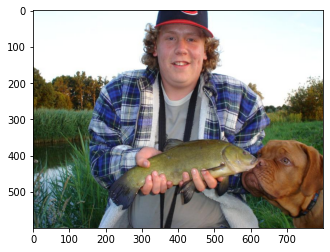

torch.Size([3, 600, 800])


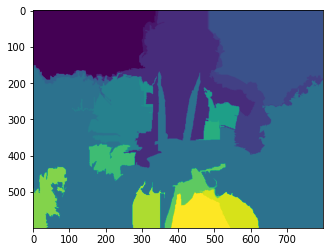

In [3]:
##Using torch codce to gen masks
import numpy as np
import torch
import skimage
import pickle
import torchvision
from skimage.segmentation import felzenszwalb
from torchvision import datasets
import matplotlib.pyplot as plt

class ImageFolderWithPaths(datasets.ImageFolder):
    """Custom dataset that includes image file paths. Extends
    torchvision.datasets.ImageFolder
    
    https://gist.github.com/andrewjong/6b02ff237533b3b2c554701fb53d5c4d
    """

    def __getitem__(self, index):
        original_tuple = super(ImageFolderWithPaths, self).__getitem__(index)
        path = self.imgs[index][0]
        tuple_with_path = (original_tuple + (path,))
        return tuple_with_path

def create_fh_mask(image, scale=1000, min_size=1000):
    print(image.shape)
    mask = felzenszwalb(image.permute(1,2,0), scale=scale, min_size=min_size)
    return torch.tensor(mask).to(torch.int8)

dataset_dir = '/shared/akash/ilsvrc/train'
# dataset_dir='/home/kkallidromitis/data/imagenet/train'

totensor = torchvision.transforms.PILToTensor()
image_dataset = ImageFolderWithPaths(dataset_dir,transform=totensor)
#291 = n01440764/n01440764_13375.JPEG
#724 = n01440764/n01440764_3849.JPEG
image_torch = image_dataset[724] 
plt.imshow(image_torch[0].permute(1,2,0))
plt.show()
mask_torch = create_fh_mask(image_torch[0])
plt.imshow(mask_torch)
plt.show()

In [ ]:
print(image_torch[2])
import pickle
mask_path = '/home/kkallidromitis/data/imagenet/masks/train/n01440764_n01440764_3849_fh.pkl'
with open(mask_path, 'rb') as f:
    mask_torch2 = pickle.load(f)
plt.imshow(mask_torch2)
plt.show()

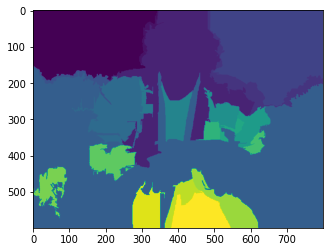

In [4]:
img_path = 'image791.pkl'
with open(img_path, 'rb') as f:
    image_tf = pickle.load(f)
plt.imshow(image_tf)
#plt.show()
mask_path = 'mask791.pkl'
with open(mask_path, 'rb') as f:
    mask_tf = pickle.load(f)
plt.imshow(mask_tf.squeeze())
plt.show()

Check Pooled Masks

In [6]:
import tensorflow as tf

def create_binary_mask(mask,max_mask_id=256,pool_size=7):
    batch_size = mask.shape[0]
    mask_ids = torch.arange(max_mask_id).reshape(1,max_mask_id, 1, 1).float()
    binary_mask = torch.eq(mask_ids, mask).float()
    binary_mask = torch.nn.AdaptiveAvgPool2d((pool_size,pool_size))(binary_mask)
    binary_mask = torch.reshape(binary_mask,(batch_size,max_mask_id,pool_size*pool_size)).permute(0,2,1)
    binary_mask = torch.argmax(binary_mask, axis=-1)
    binary_mask = torch.eye(max_mask_id)[binary_mask]
    binary_mask = binary_mask.permute(0, 2, 1)
    return binary_mask

def create_binary_mask_tf(mask,num_pixels=49,max_mask_id=256,downsample=(1, 32, 32, 1)):
    batch_size = mask.shape[0]
    mask_ids = np.arange(max_mask_id).reshape(1, 1, 1, max_mask_id)
    binary_mask = np.equal(mask_ids, mask).astype('float32')
    binary_mask = tf.nn.avg_pool(binary_mask, downsample, downsample, 'VALID')
    binary_mask = tf.reshape(binary_mask,(batch_size, num_pixels, max_mask_id))
    
    binary_mask = np.argmax(binary_mask, axis=-1)
    binary_mask = np.eye(max_mask_id)[binary_mask]
    binary_mask = np.transpose(binary_mask, [0, 2, 1])
    return binary_mask

In [7]:
from torchvision import transforms
topil = transforms.ToPILImage()
totensor = transforms.PILToTensor()
size=224
image_torch = topil(image_torch[0])
mask_torch = mask_torch.unsqueeze(0)

i, j, h, w = transforms.RandomResizedCrop.get_params(image_torch,scale=(0.08, 1.0), ratio=(3.0/4.0,4.0/3.0))
image_torch_aug = transforms.functional.resize(transforms.functional.crop(image_torch, i, j, h, w),(size,size),
                                     interpolation=transforms.functional.InterpolationMode.BICUBIC)

mask_torch_aug = transforms.functional.resize(transforms.functional.crop(mask_torch, i, j, h, w),(size,size),
                                    interpolation=transforms.functional.InterpolationMode.NEAREST)
bin_torch = create_binary_mask(mask_torch_aug)

In [8]:
from torchvision import transforms
topil = transforms.ToPILImage()
totensor = transforms.PILToTensor()
size=224
image_tf = topil(image_tf)
mask_tf = torch.tensor(mask_tf)

i, j, h, w = transforms.RandomResizedCrop.get_params(image_tf,scale=(0.08, 1.0), ratio=(3.0/4.0,4.0/3.0))
image_tf_aug = transforms.functional.resize(transforms.functional.crop(image_tf, i, j, h, w),(size,size),
                                     interpolation=transforms.functional.InterpolationMode.BICUBIC)

mask_tf_aug = transforms.functional.resize(transforms.functional.crop(mask_tf, i, j, h, w),(size,size),
                                    interpolation=transforms.functional.InterpolationMode.NEAREST)

bin_tf = create_binary_mask_tf(mask_tf_aug.unsqueeze(3).int().numpy())

2022-03-27 22:53:35.991527: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudnn.so.8'; dlerror: libcudnn.so.8: cannot open shared object file: No such file or directory
2022-03-27 22:53:35.991699: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1850] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...
2022-03-27 22:53:36.038233: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


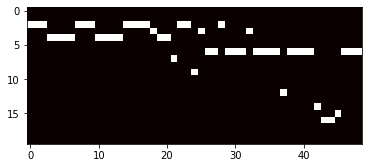

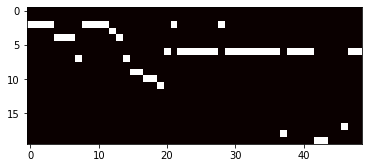

In [9]:
import matplotlib.pyplot as plt

plt.imshow(bin_torch.squeeze(0)[:20], cmap='hot', interpolation='nearest')
plt.show()

plt.imshow(bin_tf.squeeze(0)[:20], cmap='hot', interpolation='nearest')
plt.show()

Evaluate Sampling

In [ ]:
def sample_masks(binary_mask,n_masks=16):
    batch_size=binary_mask.shape[0]
    mask_exists = torch.greater(binary_mask.sum(-1), 1e-3)
    sel_masks = mask_exists.float() + 0.00000000001
    sel_masks = sel_masks / sel_masks.sum(1, keepdims=True)
    sel_masks = torch.log(sel_masks)
    
    dist = torch.distributions.categorical.Categorical(logits=sel_masks)
    mask_ids = dist.sample([n_masks]).T
    
    sample_mask = torch.stack([binary_mask[b][mask_ids[b]] for b in range(batch_size)])
    
    return sample_mask,mask_ids

def sample_masks(self, binary_mask, batch_size, n_random_vectors=16):
    """Samples which binary masks to use in the loss."""
    mask_exists = jnp.greater(binary_mask.sum(-1), 1e-3)
    sel_masks = mask_exists.astype('float32') + 0.00000000001
    sel_masks = sel_masks / sel_masks.sum(1, keepdims=True)
    sel_masks = jnp.log(sel_masks)

    mask_ids = jax.random.categorical(
        hk.next_rng_key(), sel_masks, axis=-1,
        shape=tuple([n_random_vectors, batch_size]))
    mask_ids = jnp.transpose(mask_ids, [1, 0])

    smpl_masks = jnp.stack(
        [binary_mask[b][mask_ids[b]] for b in range(batch_size)])
    return smpl_masks, mask_ids

Evaluate loss

In [ ]:
import torch
import tensorflow as tf
import numpy as np
target1 = torch.load('./rand/target1.pt').cpu().detach()
target2 = torch.load('./rand/target2.pt').cpu().detach()
pred1 = torch.load('./rand/pred1.pt').cpu().detach()
pred2 = torch.load('./rand/pred2.pt').cpu().detach()
tind1 = torch.load('./rand/tind1.pt').cpu().detach()
tind2 = torch.load('./rand/tind2.pt').cpu().detach()
pind1 = torch.load('./rand/pind1.pt').cpu().detach()
pind2 = torch.load('./rand/pind2.pt').cpu().detach()

num_rois =16
batch_size=128
temperature=0.1
max_val=1e9
infinity_proxy =1e9
import numpy as np
import torch
from torch import nn

def make_same_obj(ind_0, ind_1):
    b = ind_0.shape[0]
    same_obj = torch.eq(ind_0.reshape([b, num_rois, 1]),
                         ind_1.reshape([b, 1, num_rois]))
    return same_obj.float().unsqueeze(2)

def manual_cross_entropy(labels, logits, weight):
    ce = - weight * torch.sum(labels * torch.nn.functional.log_softmax(logits,dim = -1), dim=-1)
    return torch.mean(ce)

same_obj_aa = make_same_obj(pind1, tind1)
same_obj_ab = make_same_obj(pind1, tind2)
same_obj_ba = make_same_obj(pind2, tind1)
same_obj_bb = make_same_obj(pind2, tind2)

pred1 = torch.nn.functional.normalize(pred1,dim=-1)
pred2 = torch.nn.functional.normalize(pred2,dim=-1)
target1 = torch.nn.functional.normalize(target1,dim=-1)
target2 = torch.nn.functional.normalize(target2,dim=-1)

labels_local = torch.nn.functional.one_hot(torch.tensor(np.arange(batch_size))
                                           ,batch_size).unsqueeze(1).unsqueeze(3)

logits_aa = torch.einsum("abk,uvk->abuv", pred1, target1) / temperature
logits_bb = torch.einsum("abk,uvk->abuv", pred2, target2) / temperature
logits_ab = torch.einsum("abk,uvk->abuv", pred1, target2) / temperature
logits_ba = torch.einsum("abk,uvk->abuv", pred2, target1) / temperature

labels_aa = labels_local * same_obj_aa
labels_ab = labels_local * same_obj_ab
labels_ba = labels_local * same_obj_ba
labels_bb = labels_local * same_obj_bb

logits_aa = logits_aa - max_val * labels_local * same_obj_aa
logits_bb = logits_bb - max_val * labels_local * same_obj_bb
labels_aa = 0. * labels_aa
labels_bb = 0. * labels_bb

labels_abaa = torch.cat([labels_ab, labels_aa], axis=2)
labels_babb = torch.cat([labels_ba, labels_bb], axis=2)

labels_0 = torch.reshape(labels_abaa, [batch_size, num_rois, -1])
labels_1 = torch.reshape(labels_babb, [batch_size, num_rois, -1])

num_positives_0 = torch.sum(labels_0, axis=-1, keepdims=True)
num_positives_1 = torch.sum(labels_1, axis=-1, keepdims=True)

labels_0 = labels_0 / torch.max(num_positives_0, torch.ones(num_positives_0.shape))
labels_1 = labels_1 / torch.max(num_positives_1, torch.ones(num_positives_1.shape))

obj_area_0 = torch.sum(make_same_obj(pind1, pind1), axis=[2, 3])
obj_area_1 = torch.sum(make_same_obj(pind2, pind2), axis=[2, 3])

weights_0 = torch.greater(num_positives_0[..., 0], 1e-3).float()
weights_0 = weights_0 / obj_area_0
weights_1 = torch.greater(num_positives_1[..., 0], 1e-3).float()
weights_1 = weights_1 / obj_area_1

logits_abaa = torch.cat([logits_ab, logits_aa], axis=2)
logits_babb = torch.cat([logits_ba, logits_bb], axis=2)

logits_abaa = torch.reshape(logits_abaa, [batch_size, num_rois, -1])
logits_babb = torch.reshape(logits_babb, [batch_size, num_rois, -1])

loss_a = manual_cross_entropy(labels_0, logits_abaa, weights_0)
loss_b = manual_cross_entropy(labels_1, logits_babb, weights_1)
loss = loss_a + loss_b
print(loss,loss_a,loss_b)

In [ ]:
target1 = torch.load('./rand/target1.pt').cpu().detach()
target2 = torch.load('./rand/target2.pt').cpu().detach()
pred1 = torch.load('./rand/pred1.pt').cpu().detach()
pred2 = torch.load('./rand/pred2.pt').cpu().detach()
tind1 = torch.load('./rand/tind1.pt').cpu().detach()
tind2 = torch.load('./rand/tind2.pt').cpu().detach()
pind1 = torch.load('./rand/pind1.pt').cpu().detach()
pind2 = torch.load('./rand/pind2.pt').cpu().detach()
target1 = target1.numpy()
target2 = target2.numpy()
pred1 = pred1.numpy()
pred2 = pred2.numpy()
tind1 = tind1.numpy()
tind2 = tind2.numpy()
pind1 = pind1.numpy()
pind2 = pind2.numpy()

def manual_cross_entropy(labels, logits, weight):
  ce = - weight * np.sum(labels * tf.nn.log_softmax(logits), axis=-1)
  return np.mean(ce)

def make_same_obj(ind_0, ind_1):
    same_obj = np.equal(ind_0.reshape([batch_size, num_rois, 1]),
                     ind_1.reshape([batch_size, 1, num_rois]))
    return np.expand_dims(same_obj.astype("float64"), axis=2)

same_obj_aa = make_same_obj(pind1, tind1)
same_obj_ab = make_same_obj(pind1, tind2)
same_obj_ba = make_same_obj(pind2, tind1)
same_obj_bb = make_same_obj(pind2, tind2)

# L2 normalize the tensors to use for the cosine-similarity
pred1 = tf.math.l2_normalize(pred1, axis=-1)
pred2 = tf.math.l2_normalize(pred2, axis=-1)
target1 = tf.math.l2_normalize(target1, axis=-1)
target2 = tf.math.l2_normalize(target2, axis=-1)

target1_large = target1
target2_large = target2

labels_local = np.expand_dims(np.expand_dims(tf.one_hot(np.arange(batch_size),batch_size), axis=2), axis=1)

# Do our matmuls and mask out appropriately.
logits_aa = np.einsum("abk,uvk->abuv", pred1, target1_large) / temperature
logits_bb = np.einsum("abk,uvk->abuv", pred2, target2_large) / temperature
logits_ab = np.einsum("abk,uvk->abuv", pred1, target2_large) / temperature
logits_ba = np.einsum("abk,uvk->abuv", pred2, target1_large) / temperature

labels_aa = labels_local * same_obj_aa
labels_ab = labels_local * same_obj_ab
labels_ba = labels_local * same_obj_ba
labels_bb = labels_local * same_obj_bb

logits_aa = logits_aa - infinity_proxy * labels_local * same_obj_aa
logits_bb = logits_bb - infinity_proxy * labels_local * same_obj_bb
labels_aa = 0. * labels_aa
labels_bb = 0. * labels_bb

labels_abaa = np.concatenate([labels_ab, labels_aa], axis=2)
labels_babb = np.concatenate([labels_ba, labels_bb], axis=2)

labels_0 = np.reshape(labels_abaa, [batch_size, num_rois, -1])
labels_1 = np.reshape(labels_babb, [batch_size, num_rois, -1])

num_positives_0 = np.sum(labels_0, axis=-1, keepdims=True)
num_positives_1 = np.sum(labels_1, axis=-1, keepdims=True)

labels_0 = labels_0 / np.maximum(num_positives_0, 1)
labels_1 = labels_1 / np.maximum(num_positives_1, 1)

obj_area_0 = tf.math.reduce_sum(make_same_obj(pind1, pind1),axis=[2, 3])
obj_area_1 = tf.math.reduce_sum(make_same_obj(pind2, pind2),axis=[2, 3])

weights_0 = np.greater(num_positives_0[..., 0], 1e-3).astype("float64")
weights_0 = weights_0 / obj_area_0
weights_1 = np.greater(num_positives_1[..., 0], 1e-3).astype("float64")
weights_1 = weights_1 / obj_area_1

logits_abaa = np.concatenate([logits_ab, logits_aa], axis=2)
logits_babb = np.concatenate([logits_ba, logits_bb], axis=2)

logits_abaa = np.reshape(logits_abaa, [batch_size, num_rois, -1])
logits_babb = np.reshape(logits_babb, [batch_size, num_rois, -1])

loss_a = manual_cross_entropy(labels_0, logits_abaa, weights_0)
loss_b = manual_cross_entropy(labels_1, logits_babb, weights_1)
loss = loss_a + loss_b
print(loss,loss_a,loss_b)